<a href="https://colab.research.google.com/github/sznajder/Notebooks/blob/master/JetTagging_DGCN_TFKeras_Spektral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DGCN ( Dynamic Graph CNN for Learning on Point Clouds ) for Jet-Images



This layer computes:

$$
x_i' = \sum\limits_{j \in \mathcal{N}(i)} \textrm{MLP}\big( x_i \|
x_j - x_i \big)
$$
, where MLP is a multi-layer perceptron

\\

 OBS: Works only in single or disjoint data modes 

\\

Based on: https://arxiv.org/abs/1801.07829. by. Wang et all.

\\

Author: Andre Sznajder

In [1]:
#!fusermount -u drive
! pip install einops
! pip install --upgrade git+https://github.com/danielegrattarola/spektral.git


  Cloning https://github.com/danielegrattarola/spektral.git to /tmp/pip-req-build-3urox2wv
  Running command git clone -q https://github.com/danielegrattarola/spektral.git /tmp/pip-req-build-3urox2wv
  Created wheel for spektral: filename=spektral-1.0.5-cp37-none-any.whl size=112358 sha256=e0ebf6b6701ca807a237c3342680870aaff89bd4d48591dc4574f2325d2eeae0
  Stored in directory: /tmp/pip-ephem-wheel-cache-6husbra1/wheels/83/60/1f/a45c48d66dbbee6c98123fd345a7212bdc5b79449095a985da
Successfully built spektral
  Found existing installation: spektral 1.0.5
    Uninstalling spektral-1.0.5:
      Successfully uninstalled spektral-1.0.5


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
data_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/'

from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import scipy.sparse as sp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError , BinaryCrossentropy
from tensorflow.keras.metrics import binary_accuracy , categorical_accuracy
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, Flatten
from tensorflow.keras import utils

from spektral.layers.ops import sp_matrix_to_sp_tensor
from spektral.layers import GCNConv, EdgeConv,  GlobalSumPool, GlobalAvgPool
from spektral.data import Dataset, DisjointLoader, Graph
from spektral.data import SingleLoader, DisjointLoader, BatchLoader, MixedLoader, PackedBatchLoader
from spektral.data.loaders import SingleLoader
from spektral.transforms.normalize_adj import NormalizeAdj
from spektral.transforms import AdjToSpTensor, LayerPreprocess

Mounted at /content/gdrive


## Load numpy arrays
Here, we load the numpy arrays containing the 4D tensors of "jet-images" (see https://arxiv.org/pdf/1511.05190.pdf)

In [3]:
h5f = h5py.File(data_dir+"jet_images.h5", "r")

jet_images_dict = {}
jet_images_dict['QCD'] = h5f['QCD'][()]
jet_images_dict['TT'] = h5f['TT'][()]

h5f.close()

In [4]:
# 4D tensor (tensorflow backend)
# 1st dim is jet index
# 2nd dim is eta bin
# 3rd dim is phi bin
# 4th dim is pt value (or rgb values, etc.)
print(jet_images_dict['QCD'].ndim)
njet_qcd = jet_images_dict['QCD'].shape[0]
njet_tt = jet_images_dict['TT'].shape[0]
neta = jet_images_dict['TT'].shape[1]
nphi = jet_images_dict['TT'].shape[2]
npt = jet_images_dict['TT'].shape[3]
nfeatures = 3 # Eta,Phi,Pt of the cell
ncells = neta*nphi
print('Number of QCD jets=',njet_qcd)
print('Number of TT jets=',njet_tt)
print('Number of Phi bins=',nphi)
print('Number of Eta bins=',neta)
print('Number of Pt bins=',npt)

4
Number of QCD jets= 3305
Number of TT jets= 1821
Number of Phi bins= 30
Number of Eta bins= 30
Number of Pt bins= 1


## Plotting jet-images
Let's plot some jet-images (individual jets and averaged over all jets)

**Question 1:**  Try to plot the average W and QCD jet-images.

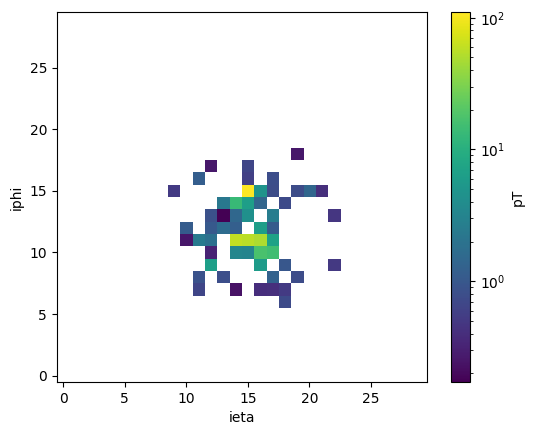

In [5]:
%matplotlib inline
plt.style.use('default')

# plot one W jet
i = 7
plt.figure('W') 
plt.imshow(jet_images_dict['TT'][i,:,:,0].T, norm=mpl.colors.LogNorm(), origin='lower', interpolation='none')
cbar = plt.colorbar()
cbar.set_label('pT')
plt.xlabel('ieta')
plt.ylabel('iphi')
plt.show()

# plot average W jet

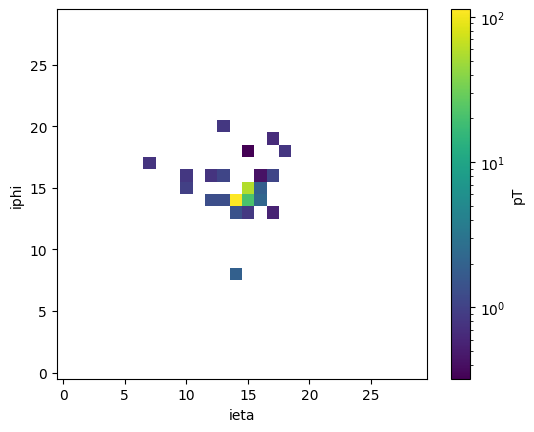

In [6]:
# plot one QCD jet
i = 7
plt.figure() 
plt.imshow(jet_images_dict['QCD'][i,:,:,0].T, norm=mpl.colors.LogNorm(), origin='lower', interpolation='none')
cbar = plt.colorbar()
cbar.set_label('pT')
plt.xlabel('ieta')
plt.ylabel('iphi')
plt.show()

# plot average QCD jet

## Create Graphs and defines class MyDataset as defined in:

https://github.com/danielegrattarola/spektral/blob/master/examples/graph_prediction/custom_dataset.py


#===============================================

# Based on SPEKTRAL library ( https://graphneural.network )

Using example from:
https://github.com/danielegrattarola/spektral/blob/master/examples/other/graph_signal_classification_mnist.py


#===============================================


In [7]:
class MyDataset(Dataset):
    """
    A dataset of Jet Image graphs.
    """

    def __init__(self, n_samples, jet_images_dict, **kwargs):
      self.n_samples = n_samples
      self.jet_images_dict = jet_images_dict
      self.n_features = 3
      self.n_out = 1
      super().__init__(**kwargs)


    def read(self):

      # Create Graphs from jet images with the following format
      #
      #  Adjacent matrix:  A[batch_size, num_nodes, num_nodes] (should be normalized in advance)
      #  Features matrix:  X[batch_size, num_nodes, num_features]
      #       

      ngraphs = len(self.jet_images_dict) # Number of graphs ( number of jets )
      
      # Concatenate signal and backgrounds data
      njet_qcd = self.jet_images_dict['QCD'].shape[0]
      njet_tt =  self.jet_images_dict['TT'].shape[0]
      jet_images = np.concatenate( [ self.jet_images_dict['TT'], self.jet_images_dict['QCD'] ] )
      jet_labels = np.concatenate( [ np.ones((njet_tt,1)), np.zeros((njet_qcd,1)) ] )

      nnodes  = ncells   # Number of graph nodes   ( number of cells/towers in a jet )
      ptmin   = 0.1      # Treshold for energy deposit 

      # Loop over jets to create a Graph
      Graphs=[]
      ng = 0
#      Y=np.zeros(1)
      for jet , label in zip(jet_images,jet_labels): 
   
        # Check if reached max # of requested graphs 
        if (ng > self.n_samples): break
        ng += 1

        # Graph nodes are the jet calo cells with features ( ieta , iphi , pt ) above treshold PTMIN 
        cells = [ [ ieta, iphi , jet[ieta,iphi,0] ] for ieta in range(neta) for iphi in range(nphi) if jet[ieta,iphi,0] > ptmin ]
        if len(cells)==0 : continue # skip jet processing if it contains no cells above treshold 
        X = np.array(cells) # transform the list of node features into a ndarray
        Y = label
        
        # Create an Adjacency matrix using KNN algorithm
        k=4
        A = kneighbors_graph(X, k)
 
#        print('Shape X=',X.shape)
#        print('Shape A=',A.shape)
#        print(' ')
#        print(' ')

        # Add graph to list
        G = Graph(x=X,a=A,y=Y)
        Graphs.append(G)

      # Number of generated Graphs
      print('Number of generated Graphs=',ng)

      # Return Graphs list              
      return Graphs

####################################################

#print('len jet_images_dict=',len(jet_images_dict))
#dataset = MyDataset( 5000, jet_images_dict, transforms=NormalizeAdj() )
dataset = MyDataset(5000,jet_images_dict)

# Dataset Parameters
n_nodes_max = max(g.n_nodes for g in dataset)
n_nodes_min = min(g.n_nodes for g in dataset)
n_out = dataset.n_out  # Dimension of the target
n_node_features = dataset.n_features  # Dimension of the target

print('Maximum number of nodes=',n_nodes_max)
print('Minimum number of nodes=',n_nodes_min)
print('Dimension of node features=', n_node_features)
print('Dimension of NN output target=', n_out)


Number of generated Graphs= 5001
Maximum number of nodes= 87
Minimum number of nodes= 7
Dimension of node features= 3
Dimension of NN output target= 1


## Split data into testing and training dataset and Create a dataset BatchLoader

We will split the data into two parts (one for training+validation and one for testing) and use early stoppping regularization.

Unlike regular data ( images or sequences ) graphs can have a variable size and we can fit them into tensors of pre-defined shape. If a graph has 10 nodes and another one has 4, we have to keep them that way.

This means that iterating over a dataset in mini-batches is not trivial and we cannot simply use the model.fit() method of Keras as-is.

We have to use a data Loader, which iterate over a graph dataset to create mini-batches. They hide a lot of the complexity behind the process, so that you don't need to think about it. 

You only need to specify the Data Mode. Each loader has a load() method that when called will return a data generator that Keras can process.

Since we're doing graph-level classification, we can use a BatchLoader

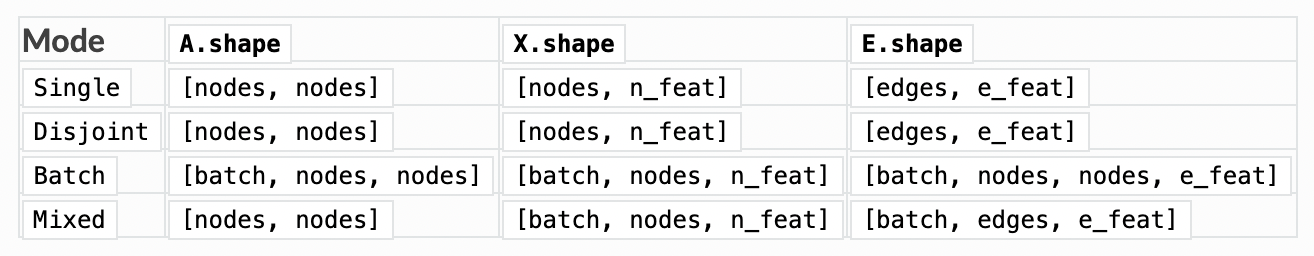


In [8]:
# Choose training parameters 
n_epochs=100
n_batch= 16
print('Number of Training Epochs=',n_epochs)
print('Size of Training Batches=',n_batch)

# Number of graphs 
ngraphs = len(dataset)
print('Number of Graphs in dataset=',ngraphs)

# Create an indices array containing random permutations of graph indices
idxs = np.random.permutation(ngraphs)

# Split indices array into train, validation and test indices ( [:split_va] , [split_va,split_te] , [split_te:] )
split_va , split_te = int(0.8 * ngraphs) , int(0.9 * ngraphs)
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te]) 

# Define the sub-datasets based on their indices
dataset_tr = dataset[idx_tr]
dataset_va = dataset[idx_va]
dataset_te = dataset[idx_te]

# Create the Spektral data loader generator ( Data Modes: Single , Disjoint , Batch , Mixed or Packed )


loader_tr = DisjointLoader(dataset_tr, batch_size=n_batch, epochs=n_epochs)
loader_va = DisjointLoader(dataset_va, batch_size=n_batch)
loader_te = DisjointLoader(dataset_te, batch_size=n_batch, epochs=1)

#loader_tr = BatchLoader(dataset_tr, batch_size=n_batch, epochs=n_epochs)
#loader_va = BatchLoader(dataset_va, batch_size=n_batch)
#loader_te = BatchLoader(dataset_te, batch_size=n_batch, epochs=1)

# Mixed mode: it's not possible to use loader.load() to train a model !!!  
#loader_tr = MixedLoader(dataset_tr, batch_size=n_batch, epochs=n_epochs)
#loader_va = MixedLoader(dataset_va, batch_size=n_batch)
#loader_te = MixedLoader(dataset_te, batch_size=n_batch, epochs=1)

#loader_tr = PackedBatchLoader(dataset_tr, batch_size=n_batch, epochs=n_epochs)
#loader_va = PackedBatchLoader(dataset_va, batch_size=n_batch)
#loader_te = PackedBatchLoader(dataset_te, batch_size=n_batch, epochs=1)


# Print train data
X = [ g.x for g in dataset_tr ]
A = [ (g.a).toarray() for g in dataset_tr ]
Y = [ g.y for g in dataset_tr ]
#
#i=2
#print('X shape=',X[i].shape)
#print('A shape=',A[i].shape)
#print('Y shape=',Y[i].shape)
#
#print('X=',X[i])
#print('A=',A[i])
#print('Y=',Y[i])


Number of Training Epochs= 100
Size of Training Batches= 16
Number of Graphs in dataset= 5001


## Define our Deep GCN model ( SPEKTRAL library )


In [9]:
# Define GCN network with two GCN layers , a pooling layer and a two final dense layers for classification

# Instantiate Tensorflow input tensors in Disjoint mode 
X = Input(shape=(n_node_features,), name="X")
A = Input(shape=(None,), sparse=True, name="A")
I = Input(shape=(), dtype=tf.int64, name="I")


# Instantiate Tensorflow input tensors in Mixed mode 
#X = Input(shape=(None,n_node_features), name="X")
#A = Input(shape=(None,), sparse=True, name="A")

# DGCN Model ( point cloud input and binary adjacency )
H = EdgeConv(n_node_features, mlp_activation="relu" , activation="relu")([X,A])
H = EdgeConv(n_node_features, mlp_activation="relu" , activation="softmax")([H,A])
print('H shape=',H.shape)
H = GlobalSumPool()([H, I])
print('H flattened shape=',H.shape)
H = Dense(int(n_nodes_max*n_node_features*10), activation="relu")(H)
O = Dense(1, activation="sigmoid") (H)


# Build the DGCN model
model = Model(inputs=[X,A,I], outputs=O)

# Define the optimizer ( minimization algorithm )
#opt = SGD(lr=0.01,decay=1e-6)
#opt = Adam(lr=0.001)
opt = Adam()
loss_fn = BinaryCrossentropy()

# Compile the model
model.compile(optimizer=opt, loss=loss_fn, weighted_metrics=["accuracy"])
#model.compile(optimizer=opt, loss=loss_fn, metrics=["accuracy"])

# print the model summary
model.summary()


H shape= (None, 3)
H flattened shape= (None, 3)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 3)]          0                                            
__________________________________________________________________________________________________
A (InputLayer)                  [(None, None)]       0                                            
__________________________________________________________________________________________________
edge_conv (EdgeConv)            (None, 3)            21          X[0][0]                          
                                                                 A[0][0]                          
__________________________________________________________________________________________________
edge_conv_1 (EdgeConv)          (None, 3)     

## Train and Evaluate the classifier

In [10]:
################################################################################
# FIT MODEL
################################################################################
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions)
        loss += sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    predictions = tf.cast(predictions,tf.float64) # Cast to fix problem with binary_accuracy
    acc = tf.reduce_mean(binary_accuracy(target, predictions))
#    acc = tf.reduce_mean(categorical_accuracy(target, predictions))     
    return loss, acc


def evaluate(loader):
    output = []
    step = 0
    while step < loader.steps_per_epoch:
        step += 1
        inputs, target = loader.__next__()
        pred = model(inputs, training=False)
        pred = tf.cast(pred,tf.float64) # Cast to fix problem with binary_accuracy
        outs = (
            loss_fn(target, pred),
            tf.reduce_mean(binary_accuracy(target, pred)),
        )
        output.append(outs)
    return np.mean(output, 0)


print("Fitting model")
current_batch = epoch = model_loss = model_acc = 0
best_val_loss = np.inf
best_weights = None
es_patience = 10 # Early stop patience

history={'loss':[],'accuracy':[],'val_loss':[],'val_accuracy':[]}
for batch in loader_tr:
    outs = train_step(*batch)
    model_loss += outs[0]
    model_acc += outs[1]
    current_batch += 1
    if current_batch == loader_tr.steps_per_epoch:
        model_loss /= loader_tr.steps_per_epoch
        model_acc /= loader_tr.steps_per_epoch
        history['loss'].append(model_loss)
        history['accuracy'].append(model_acc)

        epoch += 1

        # Compute validation loss and accuracy
        val_loss, val_acc = evaluate(loader_va)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        print(
            "Ep. {} - Loss: {:.2f} - Acc: {:.2f} - Val loss: {:.2f} - Val acc: {:.2f}".format(
                epoch, model_loss, model_acc, val_loss, val_acc
            )
        )

        # Check if loss improved for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = es_patience
            print("New best val_loss {:.3f}".format(val_loss))
            best_weights = model.get_weights()
        else:
            patience -= 1
            if patience == 0:
                print("Early stopping (best val_loss: {})".format(best_val_loss))
                break
        model_loss = 0
        model_acc = 0
        current_batch = 0

################################################################################
# EVALUATE MODEL
################################################################################
print("Testing model")
model.set_weights(best_weights)  # Load best model
test_loss, test_acc = evaluate(loader_te)
print("Done. Test loss: {:.4f}. Test acc: {:.2f}".format(test_loss, test_acc))


Fitting model
Ep. 1 - Loss: 0.71 - Acc: 0.67 - Val loss: 0.66 - Val acc: 0.67
New best val_loss 0.661
Ep. 2 - Loss: 0.70 - Acc: 0.66 - Val loss: 1.09 - Val acc: 0.52
Ep. 3 - Loss: 0.66 - Acc: 0.69 - Val loss: 0.57 - Val acc: 0.70
New best val_loss 0.572
Ep. 4 - Loss: 0.58 - Acc: 0.71 - Val loss: 0.52 - Val acc: 0.78
New best val_loss 0.518
Ep. 5 - Loss: 0.62 - Acc: 0.71 - Val loss: 0.52 - Val acc: 0.76
Ep. 6 - Loss: 0.57 - Acc: 0.73 - Val loss: 0.50 - Val acc: 0.78
New best val_loss 0.503
Ep. 7 - Loss: 0.52 - Acc: 0.75 - Val loss: 0.53 - Val acc: 0.74
Ep. 8 - Loss: 0.53 - Acc: 0.74 - Val loss: 0.54 - Val acc: 0.77
Ep. 9 - Loss: 0.50 - Acc: 0.77 - Val loss: 0.52 - Val acc: 0.75
Ep. 10 - Loss: 0.50 - Acc: 0.76 - Val loss: 0.56 - Val acc: 0.71
Ep. 11 - Loss: 0.49 - Acc: 0.76 - Val loss: 0.50 - Val acc: 0.79
New best val_loss 0.498
Ep. 12 - Loss: 0.47 - Acc: 0.78 - Val loss: 0.47 - Val acc: 0.80
New best val_loss 0.471
Ep. 13 - Loss: 0.47 - Acc: 0.78 - Val loss: 0.49 - Val acc: 0.80
Ep. 14

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

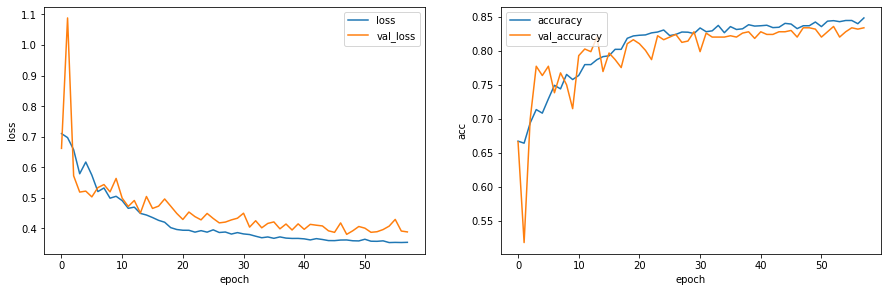

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
#
#print('History type=',history.__dict__)


# Plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history['loss'], label='loss')
ax.plot(history['val_loss'], label='val_loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# Plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history['accuracy'], label='accuracy')
ax.plot(history['val_accuracy'], label='val_accuracy')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

'''
# Plot ROC
Y_predict = gcn.predict(loader_te.load())
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
ax = plt.subplot(2, 2, 3)
ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_title('receiver operating curve')
ax.legend(loc="lower right")
'''

plt.show()


### Evaluate the Model

Here we evaluate the model prediction and compare with the target

In [12]:
'''
# EVALUATE MODEL

y_true = []
y_pred = []
for batch in loader_te:
    input, target = batch
    output = gcn(input, training=False)
    y_true.append(target)
    y_pred.append(output.numpy())

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)


# Plot DNN output 
df_sig  = df['sig'].filter(NN_VARS)
df_bkg  = df['bkg'].filter(NN_VARS)

X_sig  = np.asarray( df_sig.values ).astype(np.float32)
X_bkg  = np.asarray( df_bkg.values ).astype(np.float32)

ax = plt.subplot(3, 2, 4)
X = np.linspace(0.0, 1.0, 100)
hist_sig = ax.hist(Y_sig, bins=X, label='sig',histtype='step',lw=LINE_WIDTH)
hist_bkg = ax.hist(Y_bkg, bins=X, label='bkg',histtype='step',lw=LINE_WIDTH)
#ax.hist(Y_train_val, bins=X, label='bkg',histtype='step')
ax.set_xlabel('DNN Output')
ax.legend(prop={'size': 10})


# Plot Eff x Purity

ax = plt.subplot(3, 2, 5)
ax.plot(t, p[:-1], label='purity', lw=LINE_WIDTH)
ax.plot(t, r[:-1], label='efficiency', lw=LINE_WIDTH)
ax.set_xlabel('Cut on model score')
ax.tick_params(width=2, grid_alpha=0.5)
ax.legend()

ax = plt.subplot(3, 2, 6)
ax.plot(t,p[:-1]*r[:-1], lw=LINE_WIDTH)
ax.set_xlabel('Cut on model score')
ax.set_ylabel('Purity*Efficiency')
ax.tick_params(width=2, grid_alpha=0.5)

# Show plots
plt.show()
'''

"\n# EVALUATE MODEL\n\ny_true = []\ny_pred = []\nfor batch in loader_te:\n    input, target = batch\n    output = gcn(input, training=False)\n    y_true.append(target)\n    y_pred.append(output.numpy())\n\ny_true = np.vstack(y_true)\ny_pred = np.vstack(y_pred)\n\n\n# Plot DNN output \ndf_sig  = df['sig'].filter(NN_VARS)\ndf_bkg  = df['bkg'].filter(NN_VARS)\n\nX_sig  = np.asarray( df_sig.values ).astype(np.float32)\nX_bkg  = np.asarray( df_bkg.values ).astype(np.float32)\n\nax = plt.subplot(3, 2, 4)\nX = np.linspace(0.0, 1.0, 100)\nhist_sig = ax.hist(Y_sig, bins=X, label='sig',histtype='step',lw=LINE_WIDTH)\nhist_bkg = ax.hist(Y_bkg, bins=X, label='bkg',histtype='step',lw=LINE_WIDTH)\n#ax.hist(Y_train_val, bins=X, label='bkg',histtype='step')\nax.set_xlabel('DNN Output')\nax.legend(prop={'size': 10})\n\n\n# Plot Eff x Purity\n\nax = plt.subplot(3, 2, 5)\nax.plot(t, p[:-1], label='purity', lw=LINE_WIDTH)\nax.plot(t, r[:-1], label='efficiency', lw=LINE_WIDTH)\nax.set_xlabel('Cut on model 